In [1]:
from SimPEG import *
from simpegEM1D import (
    Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
from simpegEM1D.simulation import EM1DTMSimulation
from simpegEM1D.survey import EM1DSurveyTD
from simpegEM1D.sources import *
from simpegEM1D.receivers import *
from simpegEM1D import analytics
import numpy as np
from simpegEM1D import skytem_HM_2015
from simpegEM1D.supporting_functions.digital_filter import setFrequency, transFilt
from scipy.constants import mu_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Set up for EM1D program

## Step 1: Generate Mesh

In [2]:
hz = np.array([10, 10, 10])
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
nlay = len(depth)

## Step2: Set survey parameters

In [3]:
rx_location = np.array([10., 0., 0.])
src_location = np.array([0., 0., 0.])
times = np.logspace(-5, -2, 31)
I = 1.
a = 1.

# Receiver list
receiver_list = []
receiver_list.append(
    TimeDomainPointReceiver(
        rx_location, times, orientation="z", component="dhdt"
    )
)

# Sources
source_list = [
    TimeDomainMagneticDipoleSource(
        receiver_list=receiver_list, location=src_location, orientation="z", I=I
    )
]

# Survey
TDsurvey = EM1DSurveyTD(source_list)




## Step 3: Model and Mapping

In [4]:
sigma_half = 0.1
sigma = np.ones(hz.size) * sigma_half

chi_half = 0.
Expmap = maps.ExpMap(mesh1D)
tau =  np.ones(nlay, dtype=float)*1e-1
eta = np.ones(nlay, dtype=float)*0.5
c = np.ones(nlay, dtype=float)*0.88

In [5]:
m_1D = np.log(np.ones(nlay)*sigma_half)

In [6]:
# Conductivity
simFD = EM1DTMSimulation(
    mesh1D, survey=TDsurvey, sigmaMap=Expmap,
    chi=np.zeros(nlay)
)


bz = simFD.fields(m_1D)
print(np.shape(bz))
print(bz)

(31,)
[-9.92937941e-07 -6.17689284e-07 -3.75646836e-07 -2.24602803e-07
 -1.32533952e-07 -7.74092430e-08 -4.48521362e-08 -2.58254102e-08
 -1.47968151e-08 -8.44500782e-09 -4.80503982e-09 -2.72731327e-09
 -1.54502184e-09 -8.73921628e-10 -4.93729793e-10 -2.78671206e-10
 -1.57167471e-10 -8.85864409e-11 -4.99075897e-11 -2.81067715e-11
 -1.58245975e-11 -8.90718303e-12 -5.01227757e-12 -2.81979375e-12
 -1.58599811e-12 -8.91901941e-13 -5.01544502e-13 -2.82042815e-13
 -1.58628428e-13 -8.92263344e-14 -5.02034756e-14]


In [7]:
def analytic_solution(r, t, sigma, dtype='h'):
    """
    r: offset bewteen VMD soure and Bz receiver (m)
    t: measured times
    sigma: conductivity of the half-space earth
    """
    wt, tbase, omega_int = setFrequency(t)
    hz = analytics.Hzanal(sigma, omega_int/2/np.pi, r, 'secondary')
    if dtype=='dhdt':
        hz *= 1j*omega_int
    # Treatment for inaccuracy in analytic solutions
    ind = omega_int < 0.2
    hz[ind] = 0.
    hzTD, f0 = transFilt(hz, wt, tbase, omega_int, t)
    return hzTD*mu_0

In [8]:
bz_analytic = analytic_solution(rx_location[0]-src_location[0], times, sigma_half, 'dhdt')
print(np.shape(bz_analytic))
print(bz_analytic)

(31,)
[-9.95161669e-07 -6.20841539e-07 -3.78810288e-07 -2.25799726e-07
 -1.33069842e-07 -7.81387385e-08 -4.52134487e-08 -2.58631252e-08
 -1.49306593e-08 -8.52817273e-09 -4.81590694e-09 -2.74810393e-09
 -1.56156404e-09 -8.78911182e-10 -4.96400334e-10 -2.81652107e-10
 -1.58467449e-10 -8.88078264e-11 -5.04022696e-11 -2.83868835e-11
 -1.58432708e-11 -8.98129862e-12 -5.06659192e-12 -2.83415592e-12
 -1.59650652e-12 -9.02328531e-13 -5.05958122e-13 -2.83365433e-13
 -1.60468028e-13 -9.01946715e-14 -5.02429319e-14]


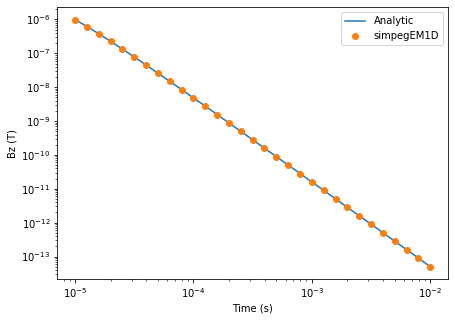

In [9]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.loglog(times, np.abs(bz_analytic), '-')
axes.loglog(times, np.abs(bz), 'o')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Bz (T)')
axes.legend(("Analytic", "simpegEM1D"))